<a href="https://colab.research.google.com/github/JacquesBLR/Causal_Inference/blob/main/Propensity_score_exercise_solution_(python).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Propensity Score exercise solution

In [ ]:
import pandas as pd
import yaml
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

import random

random.seed(1234)

In [ ]:
rhc = pd.read_csv("rhc_dataset.csv")
with open("confounders.yml", "r") as f:
    confounders = yaml.safe_load(f)

rhc["swang1"] = (rhc["swang1"] == "RHC").astype(int)
rhc["death"] = (rhc["death"] == "Yes").astype(int)
rhc.groupby("swang1")["death"].mean()


,death
swang1,
0,0.629682
1,0.680403


In [ ]:
rhc


,Unnamed: 0,cat1,cat2,ca,sadmdte,dschdte,dthdte,lstctdte,death,cardiohx,...,meta,hema,seps,trauma,ortho,adld3p,urin1,race,income,ptid
0,1,COPD,NaN,Yes,11142,11151.0,NaN,11382,0,0,...,No,No,No,No,No,0.0,NaN,white,Under $11k,5
1,2,MOSF w/Sepsis,NaN,No,11799,11844.0,11844.0,11844,1,1,...,No,No,Yes,No,No,NaN,1437.0,white,Under $11k,7
2,3,MOSF w/Malignancy,MOSF w/Sepsis,Yes,12083,12143.0,NaN,12400,0,0,...,No,No,No,No,No,NaN,599.0,white,$25-$50k,9
3,4,ARF,NaN,No,11146,11183.0,11183.0,11182,1,0,...,No,No,No,No,No,NaN,NaN,white,$11-$25k,10
4,5,MOSF w/Sepsis,NaN,No,12035,12037.0,12037.0,12036,1,0,...,No,No,No,No,No,NaN,64.0,white,Under $11k,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5730,5731,MOSF w/Sepsis,NaN,No,11867,11900.0,NaN,12074,0,1,...,No,No,Yes,No,No,NaN,1285.0,white,Under $11k,10270
5731,5732,ARF,NaN,No,12199,12241.0,12629.0,12628,1,0,...,No,No,No,No,No,0.0,1010.0,white,Under $11k,10272
5732,5733,ARF,NaN,No,12087,12093.0,12396.0,12320,1,1,...,No,No,No,No,No,1.0,4638.0,white,Under $11k,10273
5733,5734,COPD,NaN,No,11286,11309.0,11309.0,11308,1,0,...,No,No,No,No,No,NaN,NaN,white,$11-$25k,10277


# 1. Auxiliary functions

In [ ]:
def plot_results(ps_values, swang1, name=""):
    auc = round(roc_auc_score(swang1, ps_values), 4)
    sns.kdeplot(
        x=ps_values, hue=swang1, fill=True, common_norm=False, alpha=0.4
    ).set_title(f"AUC {name}:{auc}")
    plt.show()


In [ ]:
def train_model(X, y):
    parameters = {
        "learning_rate": [0.005, 0.01, 0.15, 0.2],
        "max_depth": [1, 2, 3, 4, 5],
        "n_estimators": [100, 150, 200, 300],
    }

    grid_cv = GridSearchCV(
        GradientBoostingClassifier(), parameters, scoring="roc_auc", cv=5, n_jobs=-1
    )
    grid_cv.fit(X, y)
    return grid_cv


# 2. 1. \[Propensity scores first attempt\]

Train a model for the Propensity Score (PS) with the treatment variable
*swang1*.

In [ ]:
# Transoforming categorical variables shouls be done inside the cross validation, and not before, because otherwise there can be some data leakage. In this exercise we did it directly for simplicity.

X = rhc[confounders]
X = pd.get_dummies(X)
y = rhc["swang1"]
ps_model = train_model(X, y)

These are the best hyperparameters with and its corresponding
cross-validated AUC

In [ ]:
print("Best Params")
print(ps_model.best_params_)

print("Best AUC")
print(ps_model.best_score_)

Best Params
{'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 300}
Best AUC
0.8059676296160967


*QUESTION*: As you can see, the AUC obtained with boosting is similar to
the one obtained with logistic regression. So, why using boosting
instead of logistic regression?

We know they have similar AUC a posteriory. In general boosting can fit
better to the data (because it provides nonlinear functions). So, if we
only use logistic regression, we will not know whether we could have
done better fitting using a more complex model.

# 3. 2. \[Overfitting\]

Use the trained model to make predictions (probabilities) on the same
dataset and calculate its AUC. Verify that the AUC with respect to the
predicted probabilities is higher than the AUC reported from the cross
validation.

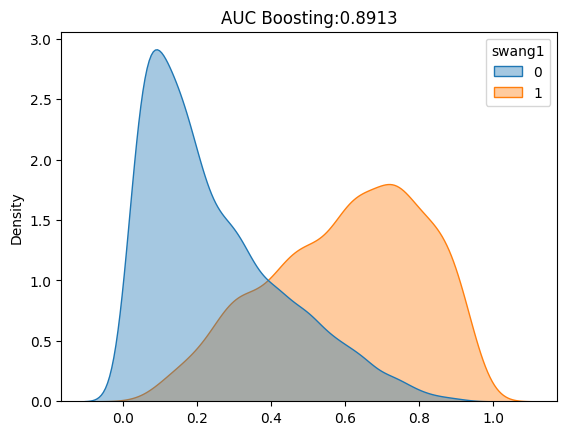

In [ ]:
ps_values = ps_model.predict_proba(X)[:, 1]

plot_results(ps_values, y, name="Boosting")

Notice that the AUC calculated with the predictions is quite higher than the reported by the cross validation. The latter is a more reliable metric than the former, so we are overfitting our dataset!

*NOTE*: You can try the same process with logistic regression. In that case you will see that, logistic regression overfits less or none at all. So, depending on the model you use, even you use cross validation, you will overfit more or less.

# 4. 3. \[Propensity scores with cross-fitting\]

Calculate the PS using 2-fold cross-fitting: split the data set into 2
equally sized data sets $D_1$ and $D_2$. Train a model for PS using
$D_1$ and predict on $D_2$, and vice versa. Calculate the AUC with the
new propensity score.

In [ ]:
# we create two datasets D1 and D2 randomly. We stratify by the outcome swang1 to guarantee a balanced dataset with respect the outcome
D1_X, D2_X, D1_y, D2_y = train_test_split(X, y, test_size=0.5, stratify=y)

ps_model_boost_1 = train_model(D1_X, D1_y)
ps_model_boost_2 = train_model(D2_X, D2_y)

# We predict on the dataset D1 using the model trained on D2 and vice versa
ps_1 = ps_model_boost_2.predict_proba(D1_X)[:, 1]
ps_2 = ps_model_boost_1.predict_proba(D2_X)[:, 1]

swang1 = pd.concat([D1_y, D2_y])
ps_values = np.concatenate([ps_1, ps_2])
print(roc_auc_score(swang1, ps_values))

0.800426645540698


The obtained AUC with the propensity scores calculated in this way is closer to the one
obtained from the cross validation

# 5. 4. \[Visual Inspection\]

Make the plot of the density of the PS by treatment group. Are the two
groups comparable?

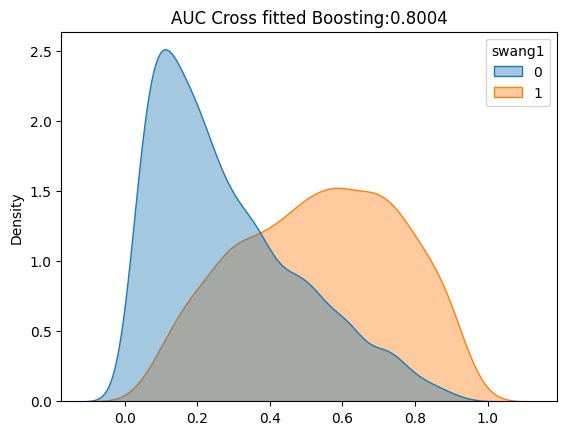

In [ ]:
plot_results(ps_values, swang1, name="Cross fitted Boosting")

Since the support of both groups is the same, they are fully comparable.

# 6. 5. \[ATEs with T-learners and cross-fitting\]

Calculate ATEs using T-learner & cross-fitting in order to estimate the
effect of swang1 to death:

## 6.1 Split the data set into 2 equally sized data sets D1 and D2

In [ ]:
X = rhc[["swang1"] + confounders]
X = pd.get_dummies(X)
y = rhc["death"]

D1_X, D2_X, D1_y, D2_y = train_test_split(X, y, test_size=0.5, stratify=y)

## 6.2 Take $D_1$ and and train two models:

-   With swang1 = RHC, called $f_{1,R}$
-   With swang1 = Non-RHC, called $f_{1,N}$

In [ ]:
data_1_rhc_X = D1_X[D1_X.swang1 == 1]
data_1_rhc_y = D1_y[D1_X.swang1 == 1]
ps_model_boost_1_rhc = train_model(data_1_rhc_X, data_1_rhc_y)

data_1_nrhc_X = D1_X[D1_X.swang1 == 0]
data_1_nrhc_y = D1_y[D1_X.swang1 == 0]
ps_model_boost_1_nrhc = train_model(data_1_nrhc_X, data_1_nrhc_y)

## 6.3 Repeat the process with $D_2$ and train two models

In [ ]:
data_2_rhc_X = D2_X[D2_X.swang1 == 1]
data_2_rhc_y = D2_y[D2_X.swang1 == 1]
ps_model_boost_2_rhc = train_model(data_2_rhc_X, data_2_rhc_y)

data_2_nrhc_X = D2_X[D2_X.swang1 == 0]
data_2_nrhc_y = D2_y[D2_X.swang1 == 0]
ps_model_boost_2_nrhc = train_model(data_2_nrhc_X, data_2_nrhc_y)

## 6.4 Calculate on $D_2$ the vector of predictions $f_{1,R}(x) - f_{1,N}(x)$ where $x$ ranges for all observations in D2.

Later, switch roles between D1 and D2 and calculate the ATE.

In [ ]:
ATE_1 = ps_model_boost_2_rhc.predict_proba(D1_X)[:, 1]
ATE_1 = ATE_1 - ps_model_boost_2_nrhc.predict_proba(D1_X)[:, 1]

ATE_2 = ps_model_boost_1_rhc.predict_proba(D2_X)[:, 1]
ATE_2 = ATE_2 - ps_model_boost_1_nrhc.predict_proba(D2_X)[:, 1]

ATE_values = np.concatenate([ATE_1, ATE_2])

In [ ]:
ATE_1 = ps_model_boost_2_rhc.predict_proba(D1_X)[:, 1]
ATE_1 = ATE_1 - ps_model_boost_2_nrhc.predict_proba(D1_X)[:, 1]
ATE_1

array([-0.015787  , -0.034179  ,  0.17050462, ...,  0.08378823,
       -0.08230849, -0.00159185])

In [ ]:
ATE_values

array([-0.015787  , -0.034179  ,  0.17050462, ..., -0.08230145,
        0.03768636,  0.02316861])

The ATE is

In [ ]:
ATE_values.mean()

0.034027523972360085